In [1]:
import warnings

warnings.filterwarnings('ignore')

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import math
from pprint import pprint
from collections import Counter
import transformers
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup

tqdm.pandas()

In [2]:
data = pd.read_csv('data.csv')

In [3]:
# remove rows with empty text
data = data[data['TEXT'] != '']

# reindex the DataFrame
data = data.reset_index(drop=True)

<Axes: ylabel='count'>

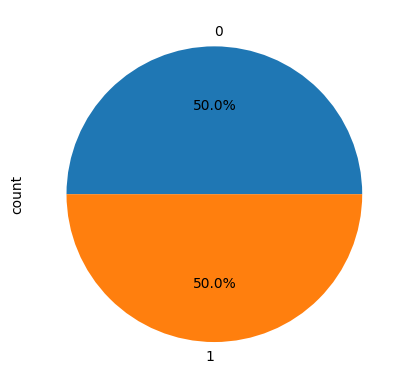

In [4]:
# create a new dataframe that contains as much data from each class as the number of rows in the class with the least rows
data_balanced = pd.concat([data[data['VAP'] == 0].sample(data[data['VAP'] == 1].shape[0]), data[data['VAP'] == 1]])
data = data_balanced
# pie chart of Label
data['VAP'].value_counts().plot.pie(autopct='%1.1f%%')

In [5]:
# split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(data['TEXT'].tolist(), data['VAP'].tolist(), test_size=0.2, random_state=42, stratify=data['VAP'].tolist())
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42, stratify=y_val)

In [6]:
model_name = 'emilyalsentzer/Bio_ClinicalBERT'

#tokenizer = transformers.BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)
#bert_model = transformers.BertModel.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

SEQ_LEN = 128
batch_size = 16
epochs = 10
learning_rate = 1e-3 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = 20
num_workers = 2

In [7]:
def get_split(text, chunk_size=128, overlap=32):
    words = text.split()
    if len(words) // chunk_size > 0:
        n_chunks = len(words) // chunk_size
    else: 
        n_chunks = 1
    chunks = []
    for i in range(n_chunks):
        start = i * chunk_size
        end = start + chunk_size
        chunks.append(" ".join(words[start:end]))
        if i != n_chunks - 1:  # Add overlap to all but the last chunk
            end += overlap
    return chunks


X_train_chunks = [get_split(text) for text in X_train]
X_val_chunks = [get_split(text) for text in X_val]
X_test_chunks = [get_split(text) for text in X_test]

In [8]:
tokenizer = transformers.BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', do_lower_case=True)

In [9]:
X_train_flattened = [chunk for text_chunks in X_train_chunks for chunk in text_chunks]
X_val_flattened = [chunk for text_chunks in X_val_chunks for chunk in text_chunks]
X_test_flattened = [chunk for text_chunks in X_test_chunks for chunk in text_chunks]

X_encoding_train = tokenizer.batch_encode_plus(
  X_train_flattened,
  max_length=SEQ_LEN,
  add_special_tokens=True,
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

X_encoding_val = tokenizer.batch_encode_plus(
    X_val_flattened,
    max_length=SEQ_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    truncation=True,
    padding='longest',
    return_attention_mask=True,
)

X_encoding_test = tokenizer.batch_encode_plus(
    X_test_flattened,
    max_length=SEQ_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    truncation=True,
    padding='longest',
    return_attention_mask=True,
)

In [10]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [11]:
X_encoding_train.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [12]:
X_train_input_ids = torch.tensor(X_encoding_train['input_ids'])
X_train_attention_mask = torch.tensor(X_encoding_train['attention_mask'])
X_train_token_type_ids = torch.tensor(X_encoding_train['token_type_ids'])

X_val_input_ids = torch.tensor(X_encoding_val['input_ids'])
X_val_attention_mask = torch.tensor(X_encoding_val['attention_mask'])
X_val_token_type_ids = torch.tensor(X_encoding_val['token_type_ids'])

X_test_input_ids = torch.tensor(X_encoding_test['input_ids'])
X_test_attention_mask = torch.tensor(X_encoding_test['attention_mask'])
X_test_token_type_ids = torch.tensor(X_encoding_test['token_type_ids'])

num_chunks_per_train_text = [len(chunks) for chunks in X_train_chunks]
num_chunks_per_val_text = [len(chunks) for chunks in X_val_chunks]
num_chunks_per_test_text = [len(chunks) for chunks in X_test_chunks]

y_train_chunks = torch.tensor([label for label, n_chunks in zip(y_train, num_chunks_per_train_text) for _ in range(n_chunks)])
y_val_chunks = torch.tensor([label for label, n_chunks in zip(y_val, num_chunks_per_val_text) for _ in range(n_chunks)])
y_test_chunks = torch.tensor([label for label, n_chunks in zip(y_test, num_chunks_per_test_text) for _ in range(n_chunks)])


print("length of training data: ", len(X_train_input_ids))
print("length of validation data: ", len(X_val_input_ids))
print("length of test data: ", len(X_test_input_ids))

train_data = torch.utils.data.TensorDataset(X_train_input_ids, X_train_attention_mask, X_train_token_type_ids, y_train_chunks)
val_data = torch.utils.data.TensorDataset(X_val_input_ids, X_val_attention_mask, X_val_token_type_ids, y_val_chunks)
test_data = torch.utils.data.TensorDataset(X_test_input_ids, X_test_attention_mask, X_test_token_type_ids, y_test_chunks)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

length of training data:  5028
length of validation data:  521
length of test data:  585


In [13]:
class TransformerModel(nn.Module):
    def __init__(self, n_classes, freeze_bert=False):
        
        super(TransformerModel,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: ", device)

model = TransformerModel(data['VAP'].nunique(), freeze_bert=False)
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 3,
    num_training_steps = steps
)

criteria = nn.CrossEntropyLoss()

Using device:  cuda:0


In [15]:
total_loss = 0
total_accuracy = 0
total_f1 = 0

for epoch in range(epochs):

    print('-' * 10)
    
    model = model.train()
    all_labels = []
    all_predictions = []

    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, batch in progress_bar:
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'token_type_ids': batch[2],
                  'labels': batch[3]}
        
        model.zero_grad()
        
        outputs = model(inputs['input_ids'], inputs['attention_mask'], inputs['token_type_ids'])
        
        loss = criteria(outputs, inputs['labels'])
        total_loss += loss.item()
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        
        scheduler.step()
        
        outputs = outputs.detach().cpu().numpy()
        labels = inputs['labels'].to('cpu').numpy()
        predictions = np.argmax(outputs, axis=1)
        all_labels.extend(labels)
        all_predictions.extend(predictions)

        progress_bar.set_description(f'Epoch {epoch + 1}/{epochs} Step {step+1}/{len(train_loader)} Loss {loss.item():.4f}')

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='weighted')

    print(f"Training Loss: {avg_loss}")
    print(f"Training Accuracy: {accuracy}")
    print(f"Training F1 Score: {f1}")
    print('-' * 10)

    # Reset total_loss for the next epoch
    total_loss = 0

----------


Epoch 1/10 Step 30/315 Loss 1.1546:  10%|▉         | 30/315 [00:08<01:24,  3.39it/s]


KeyboardInterrupt: 